In [29]:
import pandas as pd
import numpy as np
import pickle
import time

from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image

- 워드클라우드 준비(설치)

In [ ]:
## Mecab 설치

!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

     |████████████████████████████████| 19.4 MB 7.6 MB/s 
     |████████████████████████████████| 448 kB 61.6 MB/s 
Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 109 (delta 7), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (109/109), 1.27 MiB | 14.61 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-03-29 06:27:20--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::3403:4be7, 2406:da00:ff00::22c0:3470, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loc

In [112]:
stopwords1 = pd.read_csv('한국어불용어.txt', sep = '\t', header = 0)
stopwords1 = stopwords1.drop(columns = ['2','3'])
stopwords1 = stopwords1.drop_duplicates()
stopwords=[]
for i in stopwords1['1']:
    stopwords.append(i)

In [229]:
stopwords1 

,1
0,이
1,있
2,하
3,것
4,들
...,...
933,뤄
934,즈
935,뱅
936,왔


In [31]:
#from konlpy.tag import Mecab

from eunjeon import Mecab
mecab = Mecab()

In [173]:
pd.read_pickle('book1_drop.pkl')

,title,author,pubDate,isbn13,categoryID,categoryName,salesPoint,adult,rank,reviewrank,reviewtitle,review_w,text
0,자기만의 방,버지니아 울프,2022-03-10,9791190710343,51373.0,에세이,0,False,0,0.0,,0,시대를 뛰어넘어 진정한 페미니즘 비평의 장을 연 고전. 거턴 대학과 뉴넘 대학에서 ...
1,오만과 편견,제인 오스틴,2022-03-10,9791190710350,50919.0,소설/시/희곡,0,False,0,0.0,,0,"앤의서재 여성작가 클래식 2권. 지금으로부터 200년 전, 여자가 글을 쓰는 것도 ..."
2,프랑켄슈타인,메리 셸리,2022-03-10,9791190710367,50919.0,소설/시/희곡,0,False,0,0.0,,0,인류를 구할 수 있다는 ‘오만한’ 열망에 사로잡혀 연구와 실험을 거듭하고 끝내 새로...
3,[큰글씨책] 원서발췌 신선전,갈홍,2022-03-28,9791128858338,50923.0,소설/시/희곡,0,False,0,0.0,,0,신선의 행적과 장생불사를 다룬 신선설화집이자 신선전기집이다. 도교의 주요 경전으로 ...
4,원서발췌 신선전,갈홍,2022-03-28,9791128858321,50923.0,소설/시/희곡,0,False,0,0.0,,0,신선의 행적과 장생불사를 다룬 신선설화집이자 신선전기집이다. 도교의 주요 경전으로 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54369,하버드 감성지능 강의 - 인생을 성공으로 이끄는 감정 경영 수업,하버드 공개 강의 연구회,2022-03-25,9791187310631,70216.0,자기계발,210,False,0,0.0,,0,"하버드대학교에서 강조하는 감성지능의 중요성은 물론, 감정을 수용하고 나아가 이용하는..."
54370,"리빙 웰 - 더 행복하고, 더 건강하게 사는 법",리처드 템플러,2022-03-09,9791188167593,70239.0,자기계발,210,False,10,10.0,[100자평]이 책에서 만족하는 상태를 유지하기 위해 신체적으로 건...,gkfid,자기계발 고전 『The Rules』 시리즈의 저자인 리처드 템플러는 신간 『리빙 웰...
54371,50 오늘이 당신에게 가장 젊은 날입니다,나카타니 아키히로,2022-04-02,9791190865616,70219.0,자기계발,310,False,0,0.0,,0,50대에 접어들면 지금까지 살아온 인생을 돌아보아야 한다. 실제로 자신의 인생이 어...
54372,어떻게 해야 원하는 삶을 사는가 - 세계 최고의 대학이 수백 년 동안 청춘에게 던져...,데이지 웨이드먼,2022-03-28,9791191347708,70216.0,자기계발,210,False,0,0.0,,0,세계 상위 1퍼센트가 입을 모아 누구나 꼭 읽어야 한다고 극찬하는 400년 하버드대...


In [222]:
book1 = pd.read_pickle('book1_drop.pkl')
book1 = book1[['isbn13','author','text']]
book1.columns = ['isbn','author','text']
book1.head(2)

,isbn,author,text
0,9791190710343,버지니아 울프,시대를 뛰어넘어 진정한 페미니즘 비평의 장을 연 고전. 거턴 대학과 뉴넘 대학에서 ...
1,9791190710350,제인 오스틴,"앤의서재 여성작가 클래식 2권. 지금으로부터 200년 전, 여자가 글을 쓰는 것도 ..."


In [ ]:
# colab 폰트 오류
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [33]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [223]:
re = pd.read_pickle('recommend_cat_new_pred.pkl')
re = re.reset_index()
re = re.drop(columns = ['index','level_0'])
re.head()

,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred
0,9791165341909,달러구트 꿈 백화점 (50만 부 기념 드림 에디션) - 주문하신 꿈은 매진입니다,소설,379054,False,8,"[역사, 동화, 로맨스, 미스터리, 판타지, 무협]","[행복, 위로]","[일기, 동물, 사랑, 생각, 진로, 설득]",8.0
1,9791161571188,불편한 편의점 (40만부 기념 벚꽃 에디션),소설,330837,False,10,"[시대, 동화]","[위로, 힐링, 행복]","[시간, 심리, 관계, 사랑, 생각]",10.0
2,9791192186313,시맨틱 에러 포토에세이,에세이,242520,False,10,[판타지],[위로],"[사랑, 청춘, 영화, 사진]",10.0
3,9788954681179,밝은 밤 (별밤 에디션),소설,204554,False,10,"[예술, 동화, 로맨스]","[행복, 위로, 열정]","[사랑, 생각, 인생, 청춘, 관계, 시간, 가족]",10.0
4,9791165343729,달러구트 꿈 백화점 2 - 단골손님을 찾습니다,소설,191493,False,9,"[동화, 로맨스, 미스터리, 판타지, 무협]","[행복, 위로]","[사랑, 생각, 인생]",9.0


In [224]:
books_all = pd.read_pickle('books_all.pkl')
books_all = books_all[['isbn','rank_mean', 'review_title', 'review_id', 'review_rank',
        'review_text', 'rank_percentage']]
books_all.head(2)

,isbn,rank_mean,review_title,review_id,review_rank,review_text,rank_percentage
0,9791190710343,9.4,자기만의 방 - 버지니아 울프의 여성에세이,s*****0,5.0,\n\n \n시대를 뛰어넘어 진정한 페미니즘 비평의 장을 연 고전 <자기만의 방>은...,"[67%, 33%, 0%, 0%, 0%]"
1,9791190710343,9.4,#여성에세이#자기만의 방,녹**다,5.0,\n\n \n자기만의 방 버지니아 울프의 작품이다.한시대를 살다간 그녀의 삶은 기발...,"[67%, 33%, 0%, 0%, 0%]"


- 검색 함수

In [36]:
# 관심있는 것
def category(카테고리):
    if 카테고리[0][0] != '선택없음':
        return (re['categoryName'][i] in 카테고리[0])
    else:
        return True

def genresand(장르):
    if 장르[0][0] == '선택없음':
        return True
    elif (len(장르[0]) == 1):
        return (장르[0][0] in re['genres'][i])
    elif (len(장르[0]) == 2):
        return (장르[0][0] in re['genres'][i]) & (장르[0][1] in re['genres'][i])


def moodand(감성):
    if 감성[0][0] == '선택없음':
        return True
    elif (len(감성[0]) == 1):
        return (감성[0][0] in re['mood'][i])
    elif (len(감성[0]) == 2):
        return (감성[0][0] in re['mood'][i]) & (감성[0][1] in re['mood'][i])

def interestand(관심사):
    if 관심사[0][0] == '선택없음':
        return True
    elif (len(관심사[0]) == 1):
        return (관심사[0][0] in re['interest'][i])
    elif (len(관심사[0]) == 2):
        return (관심사[0][0] in re['interest'][i]) & (관심사[0][1] in re['interest'][i])
    
def genresor(장르):
    if 장르[0][0] == '선택없음':
        return True
    elif (len(장르[0]) == 1):
        return (장르[0][0] in re['genres'][i])
    elif (len(장르[0]) == 2):
        return (장르[0][0] in re['genres'][i]) | (장르[0][1] in re['genres'][i])


def moodor(감성):
    if 감성[0][0] == '선택없음':
        return True
    elif (len(감성[0]) == 1):
        return (감성[0][0] in re['mood'][i])
    elif (len(감성[0]) == 2):
        return (감성[0][0] in re['mood'][i]) | (감성[0][1] in re['mood'][i])

def interestor(관심사):
    if 관심사[0][0] == '선택없음':
        return True
    elif (len(관심사[0]) == 1):
        return (관심사[0][0] in re['interest'][i])
    elif (len(관심사[0]) == 2):
        return (관심사[0][0] in re['interest'][i]) | (관심사[0][1] in re['interest'][i])

In [24]:
# 관심없는 것

def nogenresand(장르no):
    if 장르no[0][0] == '선택없음':
        return True
    elif (len(장르no[0]) == 1):
        return (장르no[0][0] not in re['genres'][i])
    elif (len(장르no[0]) == 2):
        return (장르no[0][0] not in re['genres'][i]) & (장르no[0][1] not in re['genres'][i])


def nomoodand(감성no):
    if 감성no[0][0] == '선택없음':
        return True
    elif (len(감성no[0]) == 1):
        return (감성no[0][0] not in re['mood'][i])
    elif (len(감성no[0]) == 2):
        return (감성no[0][0] not in re['mood'][i]) & (감성no[0][1] not in re['mood'][i])

def nointerestand(관심사no):
    if 관심사no[0][0] == '선택없음':
        return True
    elif (len(관심사no[0]) == 1):
        return (관심사no[0][0] not in re['interest'][i])
    elif (len(관심사no[0]) == 2):
        return (관심사no[0][0] not in re['interest'][i]) & (관심사no[0][1] not in re['interest'][i])

- 협업필터링_1 함수

In [25]:
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)
    
    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
    
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)
    
    return rmse

In [26]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력합니다. 
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))

    break_count = 0
       
    # R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장. 
    non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]
   
    # P와 Q 매트릭스를 계속 업데이트(확률적 경사하강법)
    for step in tqdm_notebook(range(steps)):
        for i, j, r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i, :], Q[j, :].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])
       
        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)
            
    return P, Q

- 협업필터링_2 함수
(userid에 추천)

In [27]:
def get_unseen_books(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 도서정보 추출하여 Series로 반환함. 
    # 반환된 user_rating 은 도서명(title)을 index로 가지는 Series 객체임. 
    user_rating = ratings_matrix.loc[userId,:]
    
    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
    already_seen = user_rating[ user_rating > 0].index.tolist()
    
    # 모든 영화명을 list 객체로 만듬. 
    books_list = ratings_matrix.columns.tolist()
    
    # list comprehension으로 already_seen에 해당하는 book은 books_list에서 제외함. 
    unseen_list = [ book for book in books_list if book not in already_seen]
    
    return unseen_list

In [28]:
def recomm_book_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함. 
    recomm_books = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    # loc[행:열] 데이터 찾아, top_n 까지 내림차순으로 정렬
    return recomm_books

회원이십니까? : 네 / 아니요
네

아이디를 입력해주세요 : 
나*

성인입니까? : 네 / 아니요
네

원하시는 분야를 입력해주세요 : 
소설 / 에세이 / 자기계발 / 시 / 희곡 / 선택없음
소설 에세이

책을 읽을 때 선호하는 장르가 있나요? : 
시대 / 역사 / 철학 / 로맨스 / 전쟁 /  미스터리 / 예술 /  판타지 / 자서전 / 동화 / 과학 / 무협 / 선택없음
로맨스 예술

원하지 않는 장르를 입력해주세요 : 
전쟁

어떤 감성의 책을 원하세요? : 
고민 / 열정 / 도전 / 긍정 / 후회 / 행복 / 우울 / 위로 / 고통 / 자유 /                    
희망 / 슬픔 / 열망 / 비극 / 불안 / 용기 / 절망 / 불행 / 유머 / 힐링 / 선택없음
선택없음

원하지 않는 감성를 입력해주세요 : 
고통 비극

요즘 관심있는 것이 무엇인가요? : 
리더십 / 시간 / 페미니즘 / 취업 / 진로 / 비즈니스 / 설득 / 건강 / 심리 /                    
가족 / 관계 / 동물 / 사진 / 그림 / 여행 / 미술 / 영화 / 음악 / 음식 / 일기 / 자연 /                    
종교 / 사랑 / 인간 / 생각 / 사회 / 인생 / 일상 / 친구 / 성공 / 청춘 / 정치 / 취미 / 스포츠 / 선택없음
사랑 취미

원하지 않는 관심사를 입력해주세요 : 
선택없음
Wall time: 0 ns


<ipython-input-26-e777c377681d>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm_notebook(range(steps)):


  0%|          | 0/300 [00:00<?, ?it/s]

### iteration step :  0  rmse :  4.697546408453492
### iteration step :  10  rmse :  4.606670229818021
### iteration step :  20  rmse :  3.364771494117255
### iteration step :  30  rmse :  1.491410413368859
### iteration step :  40  rmse :  0.8727632286822464
### iteration step :  50  rmse :  0.6042553582212202
### iteration step :  60  rmse :  0.42878237734030045
### iteration step :  70  rmse :  0.29005531954495134
### iteration step :  80  rmse :  0.196006155306827
### iteration step :  90  rmse :  0.1362165370615015
### iteration step :  100  rmse :  0.09429326160487626
### iteration step :  110  rmse :  0.06313828161751224
### iteration step :  120  rmse :  0.041280441243146726
### iteration step :  130  rmse :  0.027728415793195835
### iteration step :  140  rmse :  0.020535638758561597
### iteration step :  150  rmse :  0.01729471462936112
### iteration step :  160  rmse :  0.01599671173498601
### iteration step :  170  rmse :  0.015493841313060454
### iteration step :  180  rms

<ipython-input-340-01fe519fdda9>:170: FutureWarning: The default value of regex will change from True to False in a future version.
  word['text'] = word['text'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ')


,title,author,categoryName,genres,mood,interest
0,복어,조경란,소설,"[예술, 동화, 로맨스]","[행복, 열정, 고민, 후회]","[가족, 생각, 사랑, 인생, 청춘, 관계, 미술, 인간, 취미]"
1,"딱 1년만, 나만 생각할게요 - 오로지 행복해지겠다는 일념으로 도전한 내면 탐구 프로젝트",마리안 파워,에세이,"[로맨스, 철학]","[열정, 도전, 고민, 행복, 후회, 자유, 용기, 위로, 희망, 불행]","[심리, 성공, 생각, 시간, 인생, 여행, 사랑, 청춘, 취미]"
2,실패를 사랑하는 직업 (리커버),요조,에세이,"[시대, 예술, 동화]","[행복, 열정, 고민, 후회, 도전]","[음악, 생각, 사랑, 인생, 청춘, 사진, 그림, 사회, 성공, 일상, 취미]"
3,열화여가 1,명효계,소설,"[무협, 로맨스, 판타지, 동화]","[행복, 열정]","[영화, 생각, 사랑, 인생, 청춘, 취미, 인간]"
4,자본주의의 적,정지아,소설,"[예술, 동화, 역사]","[행복, 위로, 도전]","[사랑, 생각, 가족, 인간, 사회, 인생, 취미]"
5,엄마는 아직도 여전히 - 엄마 박완서를 쓰고 사랑하고 그리워하다,호원숙,에세이,"[동화, 예술, 자서전]","[행복, 위로, 열정]","[가족, 사진, 그림, 시간, 사랑, 생각, 취미, 인생, 청춘, 동물, 일상, 일기]"
6,수치의 역사,김빵,소설,"[역사, 로맨스]","[고민, 행복, 위로, 후회]","[진로, 관계, 시간, 사랑, 생각, 인생, 친구, 취미]"
7,"어른의 일 - 출근, 독립, 취향 그리고 연애",손혜진,에세이,"[동화, 로맨스]","[위로, 힐링, 행복, 고민, 후회, 도전, 희망, 불행]","[친구, 사랑, 생각, 가족, 성공, 시간, 청춘, 인생, 취업, 진로, 취미]"
8,연애와 결혼 사이,최효진,소설,"[로맨스, 동화]","[행복, 위로, 열정, 도전, 희망, 용기]","[사랑, 생각, 인생, 청춘, 일상, 인간, 취미]"


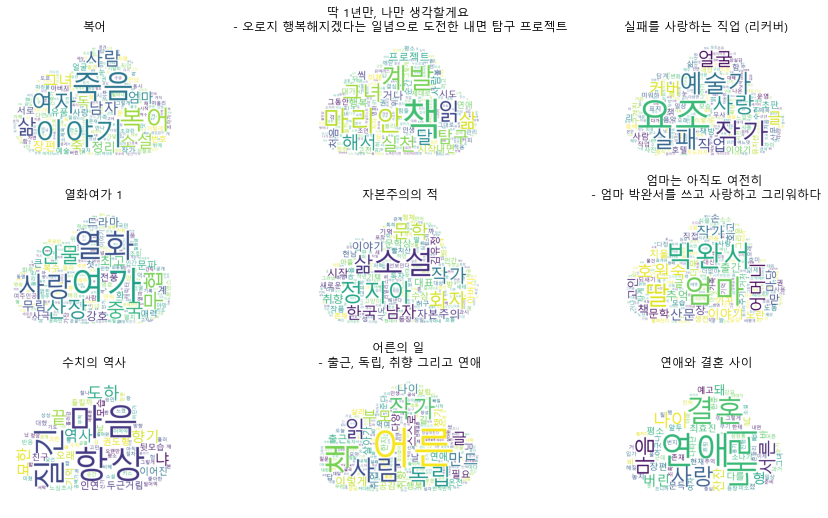

In [340]:
# 1. 검색 --------------------------------------------------------------------------------------------
카테고리 = []
장르 = []
감성 = []
관심사 = []
성인 = []
장르no = []
감성no = []
관심사no = []
성인no = []
userid = []

userid질문 = input('회원이십니까? : 네 / 아니요\n')
if userid질문 == '네':
    userid.append(input('\n아이디를 입력해주세요 : \n'))
    성인질문 = input('\n성인입니까? : 네 / 아니요\n')
else:
    성인질문 = input('\n성인입니까? : 네 / 아니요\n')

if 성인질문 == '네':
    성인.append([True,False])
    카테고리.append(input("\n원하시는 분야를 입력해주세요 : \n소설 / 에세이 / 자기계발 / 시 / 희곡 / 선택없음\n").split())
    장르.append(input('\n책을 읽을 때 선호하는 장르가 있나요? : \n시대 / 역사 / 철학 / 로맨스 / 전쟁 /  미스터리 / 예술 /  판타지 / 자서전 / 동화 / 과학 / 무협 / 선택없음\n').split())
    장르no.append(input('\n원하지 않는 장르를 입력해주세요 : \n').split())
    감성.append(input('\n어떤 감성의 책을 원하세요? : \n고민 / 열정 / 도전 / 긍정 / 후회 / 행복 / 우울 / 위로 / 고통 / 자유 /\
                    \n희망 / 슬픔 / 열망 / 비극 / 불안 / 용기 / 절망 / 불행 / 유머 / 힐링 / 선택없음\n').split())
    감성no.append(input('\n원하지 않는 감성를 입력해주세요 : \n').split())
    관심사.append(input('\n요즘 관심있는 것이 무엇인가요? : \n리더십 / 시간 / 페미니즘 / 취업 / 진로 / 비즈니스 / 설득 / 건강 / 심리 /\
                    \n가족 / 관계 / 동물 / 사진 / 그림 / 여행 / 미술 / 영화 / 음악 / 음식 / 일기 / 자연 /\
                    \n종교 / 사랑 / 인간 / 생각 / 사회 / 인생 / 일상 / 친구 / 성공 / 청춘 / 정치 / 취미 / 스포츠 / 선택없음\n').split())
    관심사no.append(input('\n원하지 않는 관심사를 입력해주세요 : \n').split())
elif 성인질문 == '아니요':
    성인.append([False])
    카테고리.append(input("\n원하시는 분야를 입력해주세요 : \n소설 / 에세이 / 자기계발 / 시 / 희곡 / 선택없음\n").split())
    장르.append(input('\n책을 읽을 때 선호하는 장르가 있나요? : \n시대 / 역사 / 철학 / 로맨스 / 전쟁 /  미스터리 / 예술 /  판타지 / 자서전 / 동화 / 과학 / 무협 / 선택없음\n').split())
    장르no.append(input('\n원하지 않는 장르를 입력해주세요 : \n').split())
    감성.append(input('\n어떤 감성의 책을 원하세요? : \n고민 / 열정 / 도전 / 긍정 / 후회 / 행복 / 우울 / 위로 / 고통 / 자유 /\
                    \n희망 / 슬픔 / 열망 / 비극 / 불안 / 용기 / 절망 / 불행 / 유머 / 힐링 / 선택없음\n').split())
    감성no.append(input('\n원하지 않는 감성를 입력해주세요 : \n').split())
    관심사.append(input('\n요즘 관심있는 것이 무엇인가요? : \n리더십 / 시간 / 페미니즘 / 취업 / 진로 / 비즈니스 / 설득 / 건강 / 심리 /\
                    \n가족 / 관계 / 동물 / 사진 / 그림 / 여행 / 미술 / 영화 / 음악 / 음식 / 일기 / 자연 /\
                    \n종교 / 사랑 / 인간 / 생각 / 사회 / 인생 / 일상 / 친구 / 성공 / 청춘 / 정치 / 취미 / 스포츠 / 선택없음\n').split())
    관심사no.append(input('\n원하지 않는 관심사를 입력해주세요 : \n').split())

select_list_and = []
for i in range(len(re)):
    if (re['adult'][i] in 성인[0]) & category(카테고리) & genresor(장르) & moodand(감성) & interestand(관심사)\
    & nogenresand(장르no) & nomoodand(감성no) & nointerestand(관심사no) :
        select_list_and.append(re.loc[i])
        
select_book_and = pd.DataFrame(select_list_and)

select_list_or = []
for i in range(len(re)):
    if (re['adult'][i] in 성인[0]) & category(카테고리) & genresor(장르) & moodor(감성) & interestor(관심사)\
    & nogenresand(장르no) & nomoodand(감성no) & nointerestand(관심사no):
        select_list_or.append(re.loc[i])
        
select_book_or = pd.DataFrame(select_list_or)

if len(select_book_and) >= 20:
    a = select_book_and
else:
    a = select_book_or

%time
# 2. 가중평점 --------------------------------------------------------------------------------------------

# 가중평점
# 상위 60%에 해당하는 rank를 최소 투표 횟수인 m으로 지정
C = re['rank_pred'].mean()
m = re['salesPoint'].quantile(0.6)

def weighted_score_average(record):
    v = record['salesPoint']
    R = record['rank_pred']
    
    return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C )

# 기존 데이터에 가중평점 칼럼 추가
a['weighted_score'] = re.apply(weighted_score_average, axis=1)
a = a.sort_values('weighted_score', ascending = False)
a = a.head(100)


# 3-1. 협업필터링 --------------------------------------------------------------------------------------------

b = pd.merge(a, books_all, on = 'isbn')
ratings_matrix = b.pivot_table('review_rank', index='review_id', columns='title')



# 경사하강법을 이용한 행렬 분해
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=300, learning_rate=0.01, r_lambda = 0.01)
# K=50 잠재요인, steps=200: 200번 반복 수행, learning rate: 학습률, r_lambda: L2 규제 계수

pred_matrix = np.dot(P, Q.T) # 행렬의 곱(내적)

ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)
ratings_matrix_T = ratings_pred_matrix.transpose()

# 도서들 간 코사인 유사도 산출
item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity() 로 반환된 넘파이 행렬을 도서명을 매핑하여 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_pred_matrix.columns,
                          columns=ratings_pred_matrix.columns)

sim_books = []

for i in range(3):
    try:
        sim_book = item_sim_df[a.loc[a.head(3).index[i]]['title']].sort_values(ascending=False)[0:3]
        sim_books.append(sim_book)
    except:
        pass
sim_books_1 = pd.DataFrame(sim_books)

col = sim_books_1.columns
sim_list = []
for i in col:
    for j in a.index:
        if a['title'][j] == i:
            sim_list.append(a.loc[j])
sim_list_df = pd.DataFrame(sim_list)

# sim_list_df : 협업필터링3-1 결과

# ---------------------------------------------------------------------------------------------------------------

# 3-2 userid 추천
# 사용자가 관람하지 않는 도서명 추출
try:   
    unseen_list = get_unseen_books(ratings_matrix, userid[0])
  # 잠재 요인 협업 필터링으로 도서 추천 
    recomm_books = recomm_book_by_userid(ratings_pred_matrix, userid[0], unseen_list, top_n=9)
    # 평점 데이타를 DataFrame으로 생성. 
    recomm_books = pd.DataFrame(data=recomm_books.values,index=recomm_books.index,columns=['pred_score'])
    recomm_books = recomm_books[recomm_books['pred_score'] > 1]

    cols2 = recomm_books.index

    recomm_list = []
    for i in cols2:
        for j in a.index:
            if a['title'][j] == i:
                recomm_list.append(a.loc[j])
    recomm_list_df = pd.DataFrame(recomm_list)

except:
    pass
# recomm_books : 협업필터링3-2 결과

# user 정보가 있으면 3-1 결과 output, 없으면 3-2 결과 output
if userid질문 == '아니요':
    recommend = sim_list_df
elif userid질문 == '네':
    try:
        recommend = recomm_list_df
    except:
        recommend = sim_list_df

recommend

# ---------------------------------------------------------------------------------------------------------------
# 워드클라우드

word = pd.merge(recommend,book1, on='isbn')
word['text'] = word['text'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ')
words_all = []
results = []

for i in word['text']:
    text = mecab.morphs(i)
    
    r=[]
    for te in text:
        r.append(te)
        words_all.append(te)
    rl = (" ".join(r)).strip() # 문장 하나 하나
    results.append(rl) # 모든 문장 append

wordclound = []
for se in results:
    result1 = []
    for w in se.split(' '):
        if w not in stopwords:
            result1.append(w)
    wordclound.append(result1)

gen_list = [] 
W, H = (100,50) 
font_path = 'C:/Windows/Fonts/malgun.ttf'
for clound in wordclound:
    mask = np.array(Image.open('cloud.png'))
    wc = WordCloud(font_path=font_path, background_color="white", width=W*10,height=H*10, mask=mask)
    c = Counter(clound) # 위에서 얻은 words를 처리하여 단어별 빈도수 형태의 딕셔너리 데이터를 구함
    gen = wc.generate_from_frequencies(c)
    gen_list.append(gen)

plt.figure(figsize = (W//7, H//7), facecolor = None)

for i in range(len(recommend)):
    plt.subplot(3, 3, i+1)  
    tit = word.loc[i]['title']
    if '-' in tit:
        tit_ = tit.split('-')
        tit = tit_[0]+'\n-'+tit_[1]
    plt.title((tit))
    plt.imshow(gen_list[i]) 
    plt.axis("off")
plt.tight_layout(pad = 0)

word[['title','author','categoryName','genres','mood','interest']]

In [341]:
userid, 성인, 카테고리, 장르, 장르no, 감성, 감성no, 관심사, 관심사no, userid질문

(['나*'],
 [[True, False]],
 [['소설', '에세이']],
 [['로맨스', '예술']],
 [['전쟁']],
 [['선택없음']],
 [['고통', '비극']],
 [['사랑', '취미']],
 [['선택없음']],
 '네')

In [337]:
if userid질문 == '아니요':
    recommend = sim_list_df
elif userid질문 == '네':
    try:
        recommend = recomm_list_df
    except:
        recommend = sim_list_df

recommend

,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred,weighted_score
1039,9791197072901,비에도 지지 않고,에세이,8258,False,10,"[동화, 판타지, 자서전, 시대]","[행복, 위로, 긍정, 도전, 희망, 용기, 비극, 불행, 힐링]","[인간, 사진, 그림, 사랑, 생각, 인생, 청춘]",10.0,9.962284
14241,9791189770105,다감 선생님은 아이들이 싫다,소설,524,False,10,"[미스터리, 판타지]","[행복, 위로, 고통, 희망, 슬픔]","[사랑, 생각, 청춘, 인생]",10.0,9.588317
4144,9788946421714,첫 마음 - 정채봉 산문집,에세이,2336,False,10,"[동화, 판타지, 예술]","[행복, 위로, 열정, 후회, 고통, 슬픔, 절망, 긍정, 자유, 희망, 열망, 용기]","[사랑, 생각, 인생, 청춘, 시간, 가족, 인간, 자연]",10.0,9.876114
11658,9791189178352,야행성동물,소설,695,False,10,"[미스터리, 판타지, 시대]","[행복, 고민, 후회, 긍정, 위로, 희망, 열망, 용기, 절망]","[가족, 동물, 생각, 사회, 인간, 인생, 청춘]",10.0,9.662342
10160,9788925799650,바람이 바다를 지날 때,소설,837,False,10,"[로맨스, 판타지]","[위로, 도전, 행복, 열정, 후회, 희망, 불행]","[사랑, 청춘, 심리, 관계, 생각, 인생, 시간, 성공]",10.0,9.706210
4848,9791160262469,포르투갈의 높은 산,소설,1965,False,10,"[역사, 미스터리, 판타지, 동화, 로맨스]","[고민, 긍정, 희망, 열망, 열정, 행복]","[일기, 사랑, 인생, 청춘, 여행, 인간, 생각, 동물, 일상]",10.0,9.855420
2897,9788963721606,"선생님, 요즘은 어떠하십니까 - 이오덕과 권정생의 아름다운 편지",에세이,3291,False,10,"[판타지, 동화]","[고민, 후회, 행복, 위로, 열정, 희망, 용기, 힐링, 자유]","[생각, 사랑, 인생, 청춘, 가족, 일기, 일상]",10.0,9.909469
8119,9791166831843,이제는 잊어도 좋겠다 - 나태주 인생 이야기,에세이,1110,False,10,"[역사, 예술, 시대, 자서전, 전쟁]","[희망, 행복, 용기]","[일기, 시간, 생각, 가족, 여행, 인생, 청춘, 일상]",10.0,9.764925
3307,9791186151488,어쩌면 동화는 어른을 위한 것 - 지친 너에게 권하는 동화속 명언 320가지,에세이,2929,False,10,"[시대, 판타지, 동화]","[행복, 위로, 도전, 희망, 용기, 열정, 힐링, 불안]","[시간, 사랑, 생각, 청춘, 인생, 일상, 친구]",10.0,9.899180


In [339]:
recomm_list_df

,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred,weighted_score
1039,9791197072901,비에도 지지 않고,에세이,8258,False,10,"[동화, 판타지, 자서전, 시대]","[행복, 위로, 긍정, 도전, 희망, 용기, 비극, 불행, 힐링]","[인간, 사진, 그림, 사랑, 생각, 인생, 청춘]",10.0,9.962284
14241,9791189770105,다감 선생님은 아이들이 싫다,소설,524,False,10,"[미스터리, 판타지]","[행복, 위로, 고통, 희망, 슬픔]","[사랑, 생각, 청춘, 인생]",10.0,9.588317
4144,9788946421714,첫 마음 - 정채봉 산문집,에세이,2336,False,10,"[동화, 판타지, 예술]","[행복, 위로, 열정, 후회, 고통, 슬픔, 절망, 긍정, 자유, 희망, 열망, 용기]","[사랑, 생각, 인생, 청춘, 시간, 가족, 인간, 자연]",10.0,9.876114
11658,9791189178352,야행성동물,소설,695,False,10,"[미스터리, 판타지, 시대]","[행복, 고민, 후회, 긍정, 위로, 희망, 열망, 용기, 절망]","[가족, 동물, 생각, 사회, 인간, 인생, 청춘]",10.0,9.662342
10160,9788925799650,바람이 바다를 지날 때,소설,837,False,10,"[로맨스, 판타지]","[위로, 도전, 행복, 열정, 후회, 희망, 불행]","[사랑, 청춘, 심리, 관계, 생각, 인생, 시간, 성공]",10.0,9.706210
4848,9791160262469,포르투갈의 높은 산,소설,1965,False,10,"[역사, 미스터리, 판타지, 동화, 로맨스]","[고민, 긍정, 희망, 열망, 열정, 행복]","[일기, 사랑, 인생, 청춘, 여행, 인간, 생각, 동물, 일상]",10.0,9.855420
2897,9788963721606,"선생님, 요즘은 어떠하십니까 - 이오덕과 권정생의 아름다운 편지",에세이,3291,False,10,"[판타지, 동화]","[고민, 후회, 행복, 위로, 열정, 희망, 용기, 힐링, 자유]","[생각, 사랑, 인생, 청춘, 가족, 일기, 일상]",10.0,9.909469
8119,9791166831843,이제는 잊어도 좋겠다 - 나태주 인생 이야기,에세이,1110,False,10,"[역사, 예술, 시대, 자서전, 전쟁]","[희망, 행복, 용기]","[일기, 시간, 생각, 가족, 여행, 인생, 청춘, 일상]",10.0,9.764925
3307,9791186151488,어쩌면 동화는 어른을 위한 것 - 지친 너에게 권하는 동화속 명언 320가지,에세이,2929,False,10,"[시대, 판타지, 동화]","[행복, 위로, 도전, 희망, 용기, 열정, 힐링, 불안]","[시간, 사랑, 생각, 청춘, 인생, 일상, 친구]",10.0,9.899180


In [330]:
word = pd.merge(recommend,book1, on='isbn')
word

,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred,weighted_score,author,text
0,9791130607283,루미너리스 2,소설,597,False,8,"[미스터리, 판타지, 시대, 역사, 동화]","[비극, 불행, 긍정, 자유, 희망, 열망, 용기, 행복, 위로, 절망]","[인생, 인간, 생각, 청춘]",8.0,8.223784,엘리너 캐턴,2013년 맨부커상 수상작. 별빛처럼 찬란하게 펼쳐지는 치밀하고 세련된 역사 미스터...
1,9791130607276,루미너리스 1,소설,737,False,9,"[미스터리, 판타지, 시대, 역사, 동화]","[비극, 불행, 긍정, 행복, 위로, 희망, 열망, 용기, 절망]","[인생, 인간, 생각, 청춘]",9.0,8.934429,엘리너 캐턴,2013년 맨부커상 수상작. 별빛처럼 찬란하게 펼쳐지는 치밀하고 세련된 역사 미스터...
2,9788952794499,달이 부서진 밤,소설,98,False,9,"[역사, 예술, 무협, 판타지, 로맨스]","[행복, 열정, 긍정, 위로, 희망, 열망, 용기, 절망]","[생각, 사랑, 인생, 청춘, 인간]",9.0,8.816067,정명섭,정명섭 작가가 자신이 가장 사랑하는 장르에 집중하여 오랜 준비 끝에 본격 괴이 시대...
3,9788954431927,해 질 무렵 안개 정원,소설,113,False,9,"[미스터리, 판타지, 역사, 예술, 전쟁]","[위로, 고통, 슬픔, 희망, 행복]","[시간, 사랑, 청춘, 미술]",9.0,8.823544,탄 트완 엥,퓨처클래식 5권. 말레이시아 문학을 이끄는 탄 트완 엥의 맨부커상 결선 진출작. 제...


# 코드 확인

## 1. 검색결과

In [304]:
select_list_and = []
for i in range(len(re)):
    if (re['adult'][i] in 성인[0]) & category(카테고리) & genresand(장르) & moodand(감성) & interestand(관심사)\
    & nogenresand(장르no) & nomoodand(감성no) & nointerestand(관심사no) :
        select_list_and.append(re.loc[i])
        
select_book_and = pd.DataFrame(select_list_and)

select_list_or = []
for i in range(len(re)):
    if (re['adult'][i] in 성인[0]) & category(카테고리) & genresor(장르) & moodor(감성) & interestor(관심사)\
    & nogenresand(장르no) & nomoodand(감성no) & nointerestand(관심사no):
        select_list_or.append(re.loc[i])
        
select_book_or = pd.DataFrame(select_list_or)

if len(select_book_and) >= 20:
    a = select_book_and
else:
    a = select_book_or

a

,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred
1435,9788984371286,내일,소설,6107,False,9,"[역사, 미스터리, 판타지, 동화, 로맨스]","[희망, 행복, 열정, 고민, 후회]","[일기, 생각, 사랑, 인생, 청춘]",9.000000
3204,9791160946628,마당을 나온 암탉 (출간 20주년 특별판),소설,3008,False,10,"[역사, 판타지, 동화, 예술, 시대]","[위로, 힐링, 행복, 희망, 열망]","[가족, 일기, 사회, 청춘, 생각, 인생]",10.000000
3513,9791190382083,모지스 할머니의 크리스마스 선물 - 해피 모지스마스!,에세이,2762,False,10,"[동화, 역사, 판타지]","[후회, 행복, 열정, 도전, 위로, 희망, 용기, 힐링, 유머]","[시간, 생각, 사진, 그림, 일기, 사랑, 인생, 청춘, 일상]",10.000000
4848,9791160262469,포르투갈의 높은 산,소설,1965,False,10,"[역사, 미스터리, 판타지, 동화, 로맨스]","[고민, 긍정, 희망, 열망, 열정, 행복]","[일기, 사랑, 인생, 청춘, 여행, 인간, 생각, 동물, 일상]",10.000000
6841,9788937461262,라셀라스,소설,1362,False,9,"[시대, 동화, 예술, 역사, 자서전, 판타지]","[유머, 행복, 희망, 불행]","[관계, 인간, 자연, 사랑, 인생, 성공]",9.000000
11171,9791130607276,루미너리스 1,소설,737,False,9,"[미스터리, 판타지, 시대, 역사, 동화]","[비극, 불행, 긍정, 행복, 위로, 희망, 열망, 용기, 절망]","[인생, 인간, 생각, 청춘]",9.000000
12999,9791130607283,루미너리스 2,소설,597,False,8,"[미스터리, 판타지, 시대, 역사, 동화]","[비극, 불행, 긍정, 자유, 희망, 열망, 용기, 행복, 위로, 절망]","[인생, 인간, 생각, 청춘]",8.000000
14106,9788950981549,나의 스웨덴에서,에세이,531,False,9,"[동화, 역사, 판타지]","[행복, 열정, 후회, 우울, 고통, 슬픔, 불안, 희망, 불행]","[사진, 그림, 일기, 생각, 사랑, 인생, 청춘, 인간, 자연, 일상, 성공]",9.000000
14317,9788965703747,"인생은 혼자 떠나는 모험이다 - 209일간의 극한 모험, 김승진 선장의 요트 세계일주",에세이,520,False,9,"[역사, 동화, 판타지]","[위로, 힐링, 열정, 도전, 행복, 긍정, 자유, 희망, 열망, 용기]","[사랑, 청춘, 일기, 성공, 생각, 인생, 인간, 자연, 여행]",9.000000
15635,9788972432210,한국인의 신화,에세이,453,False,0,"[역사, 자서전, 판타지, 동화]","[희망, 행복, 위로, 도전]","[사랑, 생각, 자연, 인간, 일상]",8.932894


## 2. 가중평점

In [305]:
# 가중평점
# 상위 60%에 해당하는 rank를 최소 투표 횟수인 m으로 지정
C = re['rank_pred'].mean()
m = re['salesPoint'].quantile(0.6)

def weighted_score_average(record):
    v = record['salesPoint']
    R = record['rank_pred']
    
    return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C )

# 기존 데이터에 가중평점 칼럼 추가
a['weighted_score'] = re.apply(weighted_score_average, axis=1)
a = a.sort_values('weighted_score', ascending = False)
a = a.head(100)
a

,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred,weighted_score
3204,9791160946628,마당을 나온 암탉 (출간 20주년 특별판),소설,3008,False,10,"[역사, 판타지, 동화, 예술, 시대]","[위로, 힐링, 행복, 희망, 열망]","[가족, 일기, 사회, 청춘, 생각, 인생]",10.000000,9.901620
3513,9791190382083,모지스 할머니의 크리스마스 선물 - 해피 모지스마스!,에세이,2762,False,10,"[동화, 역사, 판타지]","[후회, 행복, 열정, 도전, 위로, 희망, 용기, 힐링, 유머]","[시간, 생각, 사진, 그림, 일기, 사랑, 인생, 청춘, 일상]",10.000000,9.893601
4848,9791160262469,포르투갈의 높은 산,소설,1965,False,10,"[역사, 미스터리, 판타지, 동화, 로맨스]","[고민, 긍정, 희망, 열망, 열정, 행복]","[일기, 사랑, 인생, 청춘, 여행, 인간, 생각, 동물, 일상]",10.000000,9.855420
18027,9788937462511,의지와 운명 1,소설,361,False,10,"[시대, 역사, 판타지, 동화]","[비극, 불행, 행복, 열망, 긍정, 자유, 희망, 용기]","[생각, 사회, 인생, 인간, 일상]",10.000000,9.479559
19643,9788966475407,광해 1,소설,310,False,10,"[로맨스, 판타지, 역사]","[후회, 행복, 희망, 불행]","[동물, 시간, 인생, 생각, 인간, 사랑, 성공]",10.000000,9.432664
23208,9788995501429,대지를 지키는 사람들,에세이,222,False,10,"[판타지, 동화, 역사, 예술]","[행복, 희망, 불행]","[생각, 자연, 인간, 친구, 사랑, 인생, 성공]",10.000000,9.328217
24786,9791165241568,이상적인 딸이면 세계 최강이어도 예뻐해 주시나요? 1 - Novel Engine,소설,192,False,10,"[역사, 판타지, 전쟁]","[열정, 행복, 긍정, 위로, 희망, 열망, 용기, 절망]","[일기, 사랑, 인생, 청춘, 인간]",10.000000,9.283231
24781,9791136739971,후궁의 까마귀 4 - J Novel Purple,소설,192,False,10,"[미스터리, 역사, 로맨스, 판타지, 무협]","[행복, 긍정, 자유, 희망, 열망, 용기, 고통, 슬픔]","[심리, 관계, 생각]",10.000000,9.283231
26750,9791197470103,허토피아 - 모두가 꿈꿔왔던 神人이 만든 세상,소설,161,False,10,"[역사, 로맨스, 미스터리, 판타지, 무협]","[위로, 희망, 행복, 긍정, 열망, 용기, 절망]","[인생, 정치, 일상, 청춘]",10.000000,9.229946
35361,9788959868735,그대는 나의 해적 1,소설,79,False,10,"[로맨스, 판타지, 역사]","[열정, 행복, 희망, 절망, 자유, 열망, 용기]","[사랑, 인생, 청춘]",10.000000,9.041456


## 3-1. 협업필터링
- 유저 id 없을 때

In [306]:
b = pd.merge(a, books_all,  on = 'isbn')
ratings_matrix = b.pivot_table('review_rank', index='review_id', columns='title')

%time
# 경사하강법을 이용한 행렬 분해
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=300, learning_rate=0.01, r_lambda = 0.01)
# K=50 잠재요인, steps=200: 200번 반복 수행, learning rate: 학습률, r_lambda: L2 규제 계수

pred_matrix = np.dot(P, Q.T) # 행렬의 곱(내적)

ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)
ratings_matrix_T = ratings_pred_matrix.transpose()

# 도서들 간 코사인 유사도 산출
item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity() 로 반환된 넘파이 행렬을 도서명을 매핑하여 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_pred_matrix.columns,
                          columns=ratings_pred_matrix.columns)

sim_books = []
noreviews=[]
for i in range(3):
    try:
        sim_book = item_sim_df[a.loc[a.head(3).index[i]]['title']].sort_values(ascending=False)[0:3]
        sim_books.append(sim_book)
    except:
        noreview = i
        noreviews.append(noreview)
sim_books_1 = pd.DataFrame(sim_books)

col = sim_books_1.columns
cols = []
for c in col:
    cols.append(c)
for d in noreviews:
    cols.append(a.loc[a.head(3).index[d]]['title'])


sim_list = []
for i in cols:
    for j in a.index:
        if a['title'][j] == i:
            sim_list.append(a.loc[j])
sim_list_df = pd.DataFrame(sim_list)

sim_list_df

Wall time: 0 ns


<ipython-input-26-e777c377681d>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm_notebook(range(steps)):


  0%|          | 0/300 [00:00<?, ?it/s]

### iteration step :  0  rmse :  4.637874341285496
### iteration step :  10  rmse :  4.558069419884527
### iteration step :  20  rmse :  3.443258017054667
### iteration step :  30  rmse :  1.5034261637614064
### iteration step :  40  rmse :  0.8862248595177442
### iteration step :  50  rmse :  0.6281756127056098
### iteration step :  60  rmse :  0.4075418328475336
### iteration step :  70  rmse :  0.2573866061772719
### iteration step :  80  rmse :  0.16678808496178588
### iteration step :  90  rmse :  0.10427002170033986
### iteration step :  100  rmse :  0.06102892279264484
### iteration step :  110  rmse :  0.03525890682814816
### iteration step :  120  rmse :  0.02261443488664896
### iteration step :  130  rmse :  0.017688697750583484
### iteration step :  140  rmse :  0.016110257301956345
### iteration step :  150  rmse :  0.015632560807111884
### iteration step :  160  rmse :  0.015477153693022067
### iteration step :  170  rmse :  0.015418558390605786
### iteration step :  180  

,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred,weighted_score
3204,9791160946628,마당을 나온 암탉 (출간 20주년 특별판),소설,3008,False,10,"[역사, 판타지, 동화, 예술, 시대]","[위로, 힐링, 행복, 희망, 열망]","[가족, 일기, 사회, 청춘, 생각, 인생]",10.0,9.901620
26403,9791187685401,공감의 온도 - 동서문학상 수상작가 신은영이 보내는 다정한 위로,에세이,166,False,8,"[역사, 판타지, 동화, 자서전]","[위로, 힐링, 행복, 고통, 슬픔, 유머, 희망, 용기]","[가족, 심리, 관계, 일기, 생각, 사랑, 청춘, 일상, 인생]",8.0,8.452340
12999,9791130607283,루미너리스 2,소설,597,False,8,"[미스터리, 판타지, 시대, 역사, 동화]","[비극, 불행, 긍정, 자유, 희망, 열망, 용기, 행복, 위로, 절망]","[인생, 인간, 생각, 청춘]",8.0,8.223784
3513,9791190382083,모지스 할머니의 크리스마스 선물 - 해피 모지스마스!,에세이,2762,False,10,"[동화, 역사, 판타지]","[후회, 행복, 열정, 도전, 위로, 희망, 용기, 힐링, 유머]","[시간, 생각, 사진, 그림, 일기, 사랑, 인생, 청춘, 일상]",10.0,9.893601
11171,9791130607276,루미너리스 1,소설,737,False,9,"[미스터리, 판타지, 시대, 역사, 동화]","[비극, 불행, 긍정, 행복, 위로, 희망, 열망, 용기, 절망]","[인생, 인간, 생각, 청춘]",9.0,8.934429
32642,9788952794499,달이 부서진 밤,소설,98,False,9,"[역사, 예술, 무협, 판타지, 로맨스]","[행복, 열정, 긍정, 위로, 희망, 열망, 용기, 절망]","[생각, 사랑, 인생, 청춘, 인간]",9.0,8.816067
4848,9791160262469,포르투갈의 높은 산,소설,1965,False,10,"[역사, 미스터리, 판타지, 동화, 로맨스]","[고민, 긍정, 희망, 열망, 열정, 행복]","[일기, 사랑, 인생, 청춘, 여행, 인간, 생각, 동물, 일상]",10.0,9.855420
38463,9788997639953,늦게 핀 꽃이 더 아름답다,에세이,63,False,10,"[판타지, 동화, 예술, 역사, 시대, 자서전, 로맨스]","[열정, 도전, 행복, 위로, 희망, 용기]","[성공, 생각, 시간, 가족, 인생, 청춘]",10.0,8.993378


In [232]:
item_sim

array([[ 1.        ,  0.17987235, -0.05201692, ..., -0.2182527 ,
         0.28110286, -0.15203019],
       [ 0.17987235,  1.        ,  0.28673279, ..., -0.03993869,
        -0.32728717,  0.05315908],
       [-0.05201692,  0.28673279,  1.        , ...,  0.43789496,
         0.06172244,  0.28178711],
       ...,
       [-0.2182527 , -0.03993869,  0.43789496, ...,  1.        ,
         0.22091579,  0.14238959],
       [ 0.28110286, -0.32728717,  0.06172244, ...,  0.22091579,
         1.        , -0.11534189],
       [-0.15203019,  0.05315908,  0.28178711, ...,  0.14238959,
        -0.11534189,  1.        ]])

In [ ]:
noreviews

[2]

## 3-2. 유저_id 입력 도서추천

In [309]:
userid[0]

'꿈*******자'

In [310]:
# 사용자가 관람하지 않는 도서명 추출   
unseen_list = get_unseen_books(ratings_matrix, userid[0])

# 잠재 요인 협업 필터링으로 도서 추천 
recomm_books = recomm_book_by_userid(ratings_pred_matrix, userid[0], unseen_list, top_n=9)

# 평점 데이타를 DataFrame으로 생성. 
recomm_books = pd.DataFrame(data=recomm_books.values,index=recomm_books.index,columns=['pred_score'])
recomm_books = recomm_books[recomm_books['pred_score'] > 1]
recomm_books

,pred_score
title,
루미너리스 2,1.825470
루미너리스 1,1.667108
달이 부서진 밤,1.093153
해 질 무렵 안개 정원,1.041538


In [311]:
unseen_list

['공감의 온도 - 동서문학상 수상작가 신은영이 보내는 다정한 위로',
 '광해 1',
 '나만 믿고 따라와 3',
 '나의 스웨덴에서',
 '늦게 핀 꽃이 더 아름답다',
 '달이 부서진 밤',
 '대지를 지키는 사람들',
 '라셀라스',
 '루미너리스 1',
 '루미너리스 2',
 '마당을 나온 암탉 (출간 20주년 특별판)',
 '모지스 할머니의 크리스마스 선물 - 해피 모지스마스!',
 '이상적인 딸이면 세계 최강이어도 예뻐해 주시나요? 1 - Novel Engine',
 '인생은 혼자 떠나는 모험이다 - 209일간의 극한 모험, 김승진 선장의 요트 세계일주',
 '지구가 품은 비밀 1 - 영계의 사람과의 만남, 채널러가 들려주는 이야기',
 '철은 없지만 아이는 있습니다 - 아이와 함께 자라는 아빠의 실전 육아일기',
 '포르투갈의 높은 산',
 '해 질 무렵 안개 정원',
 '후궁의 까마귀 4 - J Novel Purple']

In [308]:
cols2 = recomm_books.index

recomm_list = []
for i in cols2:
    for j in a.index:
        if a['title'][j] == i:
            recomm_list.append(a.loc[j])
recomm_list_df = pd.DataFrame(recomm_list)

recomm_list_df

,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred,weighted_score
12999,9791130607283,루미너리스 2,소설,597,False,8,"[미스터리, 판타지, 시대, 역사, 동화]","[비극, 불행, 긍정, 자유, 희망, 열망, 용기, 행복, 위로, 절망]","[인생, 인간, 생각, 청춘]",8.0,8.223784
11171,9791130607276,루미너리스 1,소설,737,False,9,"[미스터리, 판타지, 시대, 역사, 동화]","[비극, 불행, 긍정, 행복, 위로, 희망, 열망, 용기, 절망]","[인생, 인간, 생각, 청춘]",9.0,8.934429
32642,9788952794499,달이 부서진 밤,소설,98,False,9,"[역사, 예술, 무협, 판타지, 로맨스]","[행복, 열정, 긍정, 위로, 희망, 열망, 용기, 절망]","[생각, 사랑, 인생, 청춘, 인간]",9.0,8.816067
30875,9788954431927,해 질 무렵 안개 정원,소설,113,False,9,"[미스터리, 판타지, 역사, 예술, 전쟁]","[위로, 고통, 슬픔, 희망, 행복]","[시간, 사랑, 청춘, 미술]",9.0,8.823544


In [216]:
word = pd.merge(recomm_list_df,book1, on='isbn')

,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred,weighted_score,author,text
0,9788956607726,정유정의 히말라야 환상방황,에세이,3553,False,9,"[역사, 자서전, 동화, 판타지]","[후회, 도전, 위로, 희망, 용기]","[일기, 인생, 시간, 여행, 생각]",9.0,8.785076,정유정,소설가 정유정의 첫 에세이. 타고난 길치인 그녀가 생애 처음 떠나기로 한 여행지는 ...
1,9791130607276,루미너리스 1,소설,737,False,9,"[미스터리, 판타지, 시대, 역사, 동화]","[비극, 불행, 긍정, 행복, 위로, 희망, 열망, 용기, 절망]","[인생, 인간, 생각, 청춘]",9.0,8.175584,엘리너 캐턴,2013년 맨부커상 수상작. 별빛처럼 찬란하게 펼쳐지는 치밀하고 세련된 역사 미스터...
2,9788952794499,달이 부서진 밤,소설,98,False,9,"[역사, 예술, 무협, 판타지, 로맨스]","[행복, 열정, 긍정, 위로, 희망, 열망, 용기, 절망]","[생각, 사랑, 인생, 청춘, 인간]",9.0,6.687442,정명섭,정명섭 작가가 자신이 가장 사랑하는 장르에 집중하여 오랜 준비 끝에 본격 괴이 시대...
3,9788963700434,살인예언자 2 - 오드 토머스와 죽음의 여신,소설,118,False,6,"[역사, 미스터리, 판타지, 동화]","[도전, 후회, 희망, 용기]","[일기, 친구]",6.0,5.864585,딘 쿤츠,38개국 언어로 번역되어 3억 2천만 부의 판매를 기록한 &lt;오드 토머스&gt;...
4,9791130607283,루미너리스 2,소설,597,False,8,"[미스터리, 판타지, 시대, 역사, 동화]","[비극, 불행, 긍정, 자유, 희망, 열망, 용기, 행복, 위로, 절망]","[인생, 인간, 생각, 청춘]",8.0,7.340392,엘리너 캐턴,2013년 맨부커상 수상작. 별빛처럼 찬란하게 펼쳐지는 치밀하고 세련된 역사 미스터...
5,9791190382083,모지스 할머니의 크리스마스 선물 - 해피 모지스마스!,에세이,2762,False,10,"[동화, 역사, 판타지]","[후회, 행복, 열정, 도전, 위로, 희망, 용기, 힐링, 유머]","[시간, 생각, 사진, 그림, 일기, 사랑, 인생, 청춘, 일상]",10.0,9.643921,애나 메리 로버트슨 모지스,&lt;인생에서 너무 늦은 때란 없습니다&gt;로 수많은 이에게 위로와 용기를 전한...


# 워드클라우드

In [281]:
recommend = recomm_list_df

In [282]:
recommend # 최종 추천 책

,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred,weighted_score
16333,9788954623353,네가 누구든 얼마나 외롭든 - 김연수 장편소설,소설,423,False,9,"[예술, 역사, 동화, 판타지, 로맨스]","[도전, 열정, 자유, 희망, 열망, 고민]","[인간, 심리, 관계, 성공, 인생, 생각]",9.0,8.904106
21195,9791167520142,"러브 앤 크라프트, 풍요실버타운의 사랑 - 여섯 가지 사랑 테라피 공식",소설,270,False,10,"[미스터리, 판타지, 시대, 역사]","[행복, 열정]","[영화, 생각, 사랑, 인생, 청춘, 페미니즘]",10.0,9.389520
12476,9788996583417,공주의 남자 1 - 조선판 로미오와 줄리엣,소설,633,False,9,"[로맨스, 판타지, 역사]","[열정, 행복, 비극, 불행]","[사랑, 인생, 청춘, 생각]",9.0,8.926758
3277,9791165796860,마술 피리 - 동화 속 범죄사건 추리 파일,소설,2950,False,9,"[역사, 판타지, 동화, 미스터리, 시대]","[열정, 도전, 고민]","[성공, 사회]",9.0,8.979690
38463,9788997639953,늦게 핀 꽃이 더 아름답다,에세이,63,False,10,"[판타지, 동화, 예술, 역사, 시대, 자서전, 로맨스]","[열정, 도전, 행복, 위로, 희망, 용기]","[성공, 생각, 시간, 가족, 인생, 청춘]",10.0,8.993378
9661,9788973810642,타라 덩컨 12 - 상 - 최후의 전투,소설,891,False,9,"[역사, 판타지, 동화, 로맨스, 미스터리, 무협]","[열정, 행복]","[일기, 사랑, 인생, 청춘, 친구]",9.0,8.943232
14317,9788965703747,"인생은 혼자 떠나는 모험이다 - 209일간의 극한 모험, 김승진 선장의 요트 세계일주",에세이,520,False,9,"[역사, 동화, 판타지]","[위로, 힐링, 열정, 도전, 행복, 긍정, 자유, 희망, 열망, 용기]","[사랑, 청춘, 일기, 성공, 생각, 인생, 인간, 자연, 여행]",9.0,8.916092
10239,9788994300313,빛나거나 미치거나 1,소설,829,False,9,"[로맨스, 판타지, 역사, 무협]","[열정, 행복, 비극, 불행]","[정치, 사랑, 인생, 청춘, 인간]",9.0,8.939989
3797,9788931006476,지킬 박사와 하이드,소설,2531,False,9,"[판타지, 시대, 역사, 동화]","[열정, 행복, 열망]","[인간, 사랑, 인생, 청춘, 사회]",9.0,8.976637


In [335]:
word = pd.merge(recommend,book1, on='isbn')
word

,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred,weighted_score,author,text
0,9791197072901,비에도 지지 않고,에세이,8258,False,10,"[동화, 판타지, 자서전, 시대]","[행복, 위로, 긍정, 도전, 희망, 용기, 비극, 불행, 힐링]","[인간, 사진, 그림, 사랑, 생각, 인생, 청춘]",10.0,9.962284,미야자와 겐지,곽수진의 따뜻하면서도 희망찬 그림으로 바라본 미야자와 겐지의 묵직한 울림이 담긴 시...
1,9791189770105,다감 선생님은 아이들이 싫다,소설,524,False,10,"[미스터리, 판타지]","[행복, 위로, 고통, 희망, 슬픔]","[사랑, 생각, 청춘, 인생]",10.0,9.588317,공민철,큰 슬픔으로 흩어졌던 마음의 퍼즐을 맞춰 가는 휴먼 미스터리 연작소설. 국내 미스터...
2,9788946421714,첫 마음 - 정채봉 산문집,에세이,2336,False,10,"[동화, 판타지, 예술]","[행복, 위로, 열정, 후회, 고통, 슬픔, 절망, 긍정, 자유, 희망, 열망, 용기]","[사랑, 생각, 인생, 청춘, 시간, 가족, 인간, 자연]",10.0,9.876114,정채봉,2021년은 작가 정채봉이 짧은 생을 마감한 지 20년이 되는 해이다. 평생 소년의...
3,9791189178352,야행성동물,소설,695,False,10,"[미스터리, 판타지, 시대]","[행복, 고민, 후회, 긍정, 위로, 희망, 열망, 용기, 절망]","[가족, 동물, 생각, 사회, 인간, 인생, 청춘]",10.0,9.662342,황희,황희 장편소설. 황희 작가의 전작인 &lt;부유하는 혼&gt;에서는 호러적인 감각이...
4,9788925799650,바람이 바다를 지날 때,소설,837,False,10,"[로맨스, 판타지]","[위로, 도전, 행복, 열정, 후회, 희망, 불행]","[사랑, 청춘, 심리, 관계, 생각, 인생, 시간, 성공]",10.0,9.706210,진주,진주의 로맨스 소설. 매순간 저 여자 이수안을 의식한다. 한정된 시간. 경계심을 늦...
5,9791160262469,포르투갈의 높은 산,소설,1965,False,10,"[역사, 미스터리, 판타지, 동화, 로맨스]","[고민, 긍정, 희망, 열망, 열정, 행복]","[일기, 사랑, 인생, 청춘, 여행, 인간, 생각, 동물, 일상]",10.0,9.855420,얀 마텔,전 세계 누적 판매 1000만 부 돌파를 기록한 맨부커상 최대 베스트셀러 『파이 이...
6,9788963721606,"선생님, 요즘은 어떠하십니까 - 이오덕과 권정생의 아름다운 편지",에세이,3291,False,10,"[판타지, 동화]","[고민, 후회, 행복, 위로, 열정, 희망, 용기, 힐링, 자유]","[생각, 사랑, 인생, 청춘, 가족, 일기, 일상]",10.0,9.909469,"이오덕, 권정생","1973년 1월, 이오덕은 권정생을 찾아갔다. 그때부터 두 사람은 평생을 함께하며 ..."
7,9791166831843,이제는 잊어도 좋겠다 - 나태주 인생 이야기,에세이,1110,False,10,"[역사, 예술, 시대, 자서전, 전쟁]","[희망, 행복, 용기]","[일기, 시간, 생각, 가족, 여행, 인생, 청춘, 일상]",10.0,9.764925,나태주,\n우리의 가장 가까운 과거 세대의 생생한 삶과 풍경을 재현해낸 자전적 기록이다. ...
8,9791186151488,어쩌면 동화는 어른을 위한 것 - 지친 너에게 권하는 동화속 명언 320가지,에세이,2929,False,10,"[시대, 판타지, 동화]","[행복, 위로, 도전, 희망, 용기, 열정, 힐링, 불안]","[시간, 사랑, 생각, 청춘, 인생, 일상, 친구]",10.0,9.899180,이서희,"어린 시절에는 행복했던 시간도 슬펐던 시간도, 또 혼란스럽고 아픈 시간도 있었을 것..."


In [284]:
word['text'] = word['text'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ')

<ipython-input-284-542af68af1e8>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  word['text'] = word['text'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ')


In [285]:
words_all = []
results = []

for i in word['text']:
    text = mecab.morphs(i)
    
    r=[]
    for te in text:
        r.append(te)
        words_all.append(te)
    rl = (" ".join(r)).strip() # 문장 하나 하나
    results.append(rl) # 모든 문장 append
results

['문학 동네 한 국문학 전집 시리즈 권 김연수 작가 의 장편 소설 로 우리 가 지나온 시절 에 대한 회의 와 진실 에 대한 열망 으로 이루 어 낸 작품 이 다 작가 는 이 작품 을 통해 소설 은 인간 개인 과 역사 의 관계 를 어떻게 서술 하 는가 라는 질문 을 던지 고 또한 그 답 을 찾 는다 문학 동네 한 국문학 전집 시리즈 권 밀도 높 고 아름다운 문장 우아 하 고 재치 있 는 유머 그리고 그 안 에 자연 스럽 게 녹아든 진지 한 문제 의식 으로 자신 의 작품 세계 를 다른 어떤 것 으로 도 대체 할 수 없 는 하나 의 장르 로 굳혀 온 김연수 의 장편 소설 이 다 우리 가 지나온 시절 에 대한 회의 와 진실 에 대한 열망 으로 이루 어 낸 작품 이 다 이 장편 소설 은 공식 적 인 역사 기술 이 지워 낸 개별 적 인 인간 들 의 이야기 를 복원 하 는 데 에 성공 함 으로써 한국 소설 의 인식 론 적 깊이 를 심화 시킨 작품 으로 평가 되 고 있 다 작가 는 이 작품 을 통해 소설 은 인간 개인 과 역사 의 관계 를 어떻게 서술 하 는가 라는 질문 을 던지 고 또한 그 답 을 찾 는다 년 월 한 국문학 의 새로운 플랫폼 이 고자 문 을 열 었 던 문학 동네 가 창립 주년 을 맞 아 문학 동네 한 국문학 전집 을 발간 그 첫 스무 권 을 선보인다 문학 의 위기 문학 의 죽음 은 언제나 현재 진행 형 이 다 그래서 문학 의 황금기 는 언제나 과거 에 존재 한다 시간 의 주름 을 펼치 고 그 속 에서 불멸 의 성좌 를 찾아내 야 한다 과거 를 지금 여기 로 호출 하 지 않 고서 는 현재 에 대한 의미 부여 미래 에 대한 상상 은 불 가능 하 다 미래 전망 은 기억 을 예언 으로 승화 하 는 일 이 다 과거 를 재 발견 재정 의 하 지 않 고서 는 더 나 은 세상 을 꿈꿀 수 없 다 문학 동네 가 한국 문학 전집 을 새로 엮 어 내 는 이유 가 여기 에 있 다 문학 동네 한 국문학 전집 은 지난 년 간 문학 동네 를 통해 독자 와 만 나온 한국 문학 의 빛나

In [286]:
wordclound = []
for se in results:
    result1 = []
    for w in se.split(' '):
        if w not in stopwords:
            result1.append(w)
    wordclound.append(result1)


In [239]:
import matplotlib.font_manager as fm
fl = fm.FontProperties(fname = 'C:/Windows/Fonts/malgun.ttf').get_name()
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

In [287]:
gen_list = [] 
W, H = (100,50) 
font_path = 'C:/Windows/Fonts/malgun.ttf'
for clound in wordclound:
    mask = np.array(Image.open('cloud.png'))
    wc = WordCloud(font_path=font_path, background_color="white", width=W*10,height=H*10, mask=mask)
    c = Counter(clound) # 위에서 얻은 words를 처리하여 단어별 빈도수 형태의 딕셔너리 데이터를 구함
    gen = wc.generate_from_frequencies(c)
    gen_list.append(gen)

In [93]:
plt.rc('font', family=fl)

In [95]:
word.loc[0]['title'].split('-')

['당연한 것을 당연하지 않게 ', ' 유별난 여성이 아니라 온전한 내가 되기까지']

In [ ]:
plt.title()

,title,author,categoryName,genres,mood,interest
0,네가 누구든 얼마나 외롭든 - 김연수 장편소설,김연수,소설,"[예술, 역사, 동화, 판타지, 로맨스]","[도전, 열정, 자유, 희망, 열망, 고민]","[인간, 심리, 관계, 성공, 인생, 생각]"
1,"러브 앤 크라프트, 풍요실버타운의 사랑 - 여섯 가지 사랑 테라피 공식",김재희,소설,"[미스터리, 판타지, 시대, 역사]","[행복, 열정]","[영화, 생각, 사랑, 인생, 청춘, 페미니즘]"
2,공주의 남자 1 - 조선판 로미오와 줄리엣,이용연,소설,"[로맨스, 판타지, 역사]","[열정, 행복, 비극, 불행]","[사랑, 인생, 청춘, 생각]"
3,마술 피리 - 동화 속 범죄사건 추리 파일,찬호께이,소설,"[역사, 판타지, 동화, 미스터리, 시대]","[열정, 도전, 고민]","[성공, 사회]"
4,늦게 핀 꽃이 더 아름답다,문영숙,에세이,"[판타지, 동화, 예술, 역사, 시대, 자서전, 로맨스]","[열정, 도전, 행복, 위로, 희망, 용기]","[성공, 생각, 시간, 가족, 인생, 청춘]"
5,타라 덩컨 12 - 상 - 최후의 전투,소피 오두인 마미코니안,소설,"[역사, 판타지, 동화, 로맨스, 미스터리, 무협]","[열정, 행복]","[일기, 사랑, 인생, 청춘, 친구]"
6,"인생은 혼자 떠나는 모험이다 - 209일간의 극한 모험, 김승진 선장의 요트 세계일주",김승진,에세이,"[역사, 동화, 판타지]","[위로, 힐링, 열정, 도전, 행복, 긍정, 자유, 희망, 열망, 용기]","[사랑, 청춘, 일기, 성공, 생각, 인생, 인간, 자연, 여행]"
7,빛나거나 미치거나 1,현고운,소설,"[로맨스, 판타지, 역사, 무협]","[열정, 행복, 비극, 불행]","[정치, 사랑, 인생, 청춘, 인간]"
8,지킬 박사와 하이드,로버트 루이스 스티븐슨,소설,"[판타지, 시대, 역사, 동화]","[열정, 행복, 열망]","[인간, 사랑, 인생, 청춘, 사회]"


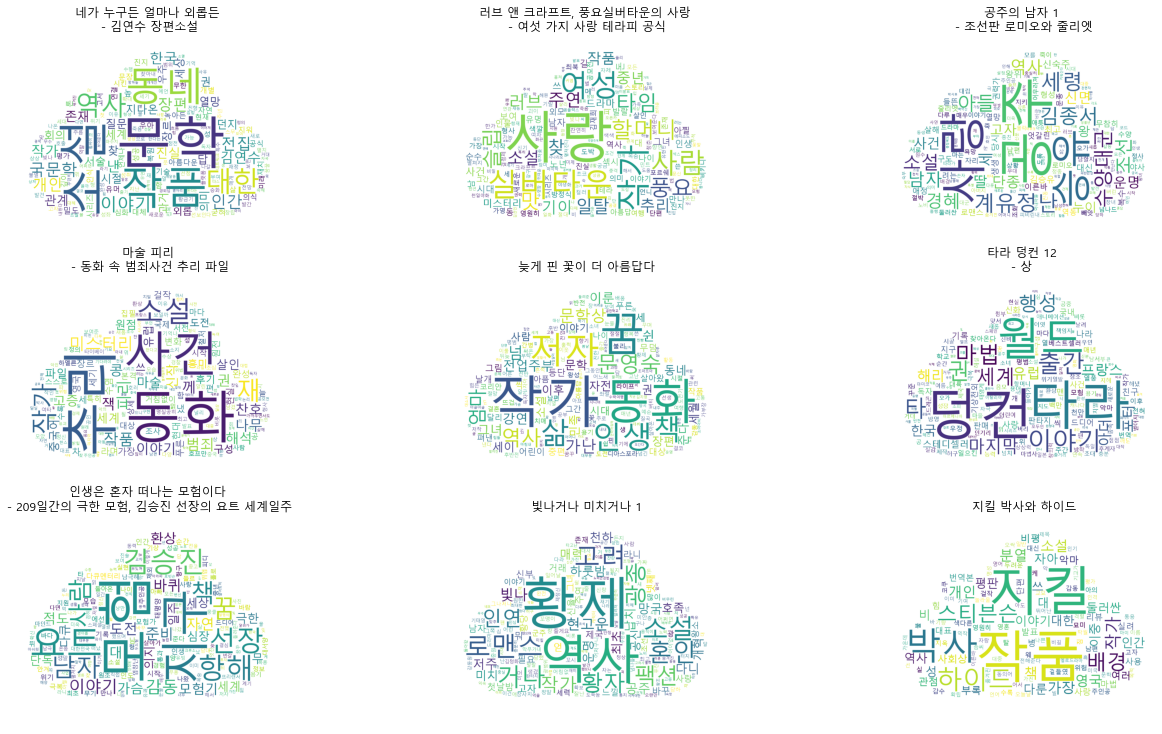

In [293]:
plt.figure(figsize = (W//5, H//5), facecolor = None)

for i in range(len(recommend)):
    plt.subplot(3,3, i+1)  
    tit = word.loc[i]['title']
    if '-' in tit:
        tit_ = tit.split('-')
        tit = tit_[0]+'\n-'+tit_[1]
    plt.title((tit))
    plt.imshow(gen_list[i]) 
    plt.axis("off")
plt.tight_layout(pad = 0)


word[['title','author','categoryName','genres','mood','interest']]

In [ ]:
word.loc[0][['title','author','categoryName','genres','mood','interest']]

title                    창문 넘어 도망친 100세 노인 (리커버)
author                                  요나스 요나손 
categoryName                                  소설
genres                         [역사, 동화, 로맨스, 전쟁]
mood                    [도전, 고민, 후회, 행복, 희망, 불행]
interest        [생각, 시간, 사회, 정치, 인생, 청춘, 사랑, 성공]
Name: 0, dtype: object

<ipython-input-333-1bff59739135>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  word2['text'] = word2['text'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ')


,title,author,categoryName,genres,mood,interest
0,비에도 지지 않고,미야자와 겐지,에세이,"[동화, 판타지, 자서전, 시대]","[행복, 위로, 긍정, 도전, 희망, 용기, 비극, 불행, 힐링]","[인간, 사진, 그림, 사랑, 생각, 인생, 청춘]"
1,다감 선생님은 아이들이 싫다,공민철,소설,"[미스터리, 판타지]","[행복, 위로, 고통, 희망, 슬픔]","[사랑, 생각, 청춘, 인생]"
2,첫 마음 - 정채봉 산문집,정채봉,에세이,"[동화, 판타지, 예술]","[행복, 위로, 열정, 후회, 고통, 슬픔, 절망, 긍정, 자유, 희망, 열망, 용기]","[사랑, 생각, 인생, 청춘, 시간, 가족, 인간, 자연]"
3,야행성동물,황희,소설,"[미스터리, 판타지, 시대]","[행복, 고민, 후회, 긍정, 위로, 희망, 열망, 용기, 절망]","[가족, 동물, 생각, 사회, 인간, 인생, 청춘]"
4,바람이 바다를 지날 때,진주,소설,"[로맨스, 판타지]","[위로, 도전, 행복, 열정, 후회, 희망, 불행]","[사랑, 청춘, 심리, 관계, 생각, 인생, 시간, 성공]"
5,포르투갈의 높은 산,얀 마텔,소설,"[역사, 미스터리, 판타지, 동화, 로맨스]","[고민, 긍정, 희망, 열망, 열정, 행복]","[일기, 사랑, 인생, 청춘, 여행, 인간, 생각, 동물, 일상]"
6,"선생님, 요즘은 어떠하십니까 - 이오덕과 권정생의 아름다운 편지","이오덕, 권정생",에세이,"[판타지, 동화]","[고민, 후회, 행복, 위로, 열정, 희망, 용기, 힐링, 자유]","[생각, 사랑, 인생, 청춘, 가족, 일기, 일상]"
7,이제는 잊어도 좋겠다 - 나태주 인생 이야기,나태주,에세이,"[역사, 예술, 시대, 자서전, 전쟁]","[희망, 행복, 용기]","[일기, 시간, 생각, 가족, 여행, 인생, 청춘, 일상]"
8,어쩌면 동화는 어른을 위한 것 - 지친 너에게 권하는 동화속 명언 320가지,이서희,에세이,"[시대, 판타지, 동화]","[행복, 위로, 도전, 희망, 용기, 열정, 힐링, 불안]","[시간, 사랑, 생각, 청춘, 인생, 일상, 친구]"


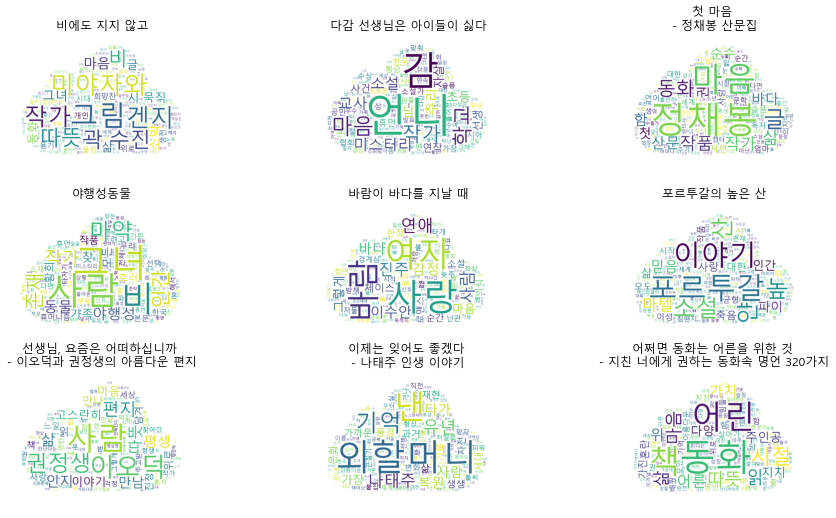

In [333]:
word2 = pd.merge(recommend,book1, on='isbn')
word2['text'] = word2['text'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ')
words_all = []
results = []

for i in word2['text']:
    text = mecab.morphs(i)
    
    r=[]
    for te in text:
        r.append(te)
        words_all.append(te)
    rl = (" ".join(r)).strip() # 문장 하나 하나
    results.append(rl) # 모든 문장 append

wordclound = []
for se in results:
    result1 = []
    for w in se.split(' '):
        if w not in stopwords:
            result1.append(w)
    wordclound.append(result1)

gen_list = [] 
W, H = (100,50) 
font_path = 'C:/Windows/Fonts/malgun.ttf'
for clound in wordclound:
    mask = np.array(Image.open('cloud.png'))
    wc = WordCloud(font_path=font_path, background_color="white", width=W*10,height=H*10, mask=mask)
    c = Counter(clound) # 위에서 얻은 words를 처리하여 단어별 빈도수 형태의 딕셔너리 데이터를 구함
    gen = wc.generate_from_frequencies(c)
    gen_list.append(gen)

plt.figure(figsize = (W//7, H//7), facecolor = None)

for i in range(len(recommend)):
    plt.subplot(3, 3, i+1)  
    tit = word2.loc[i]['title']
    if '-' in tit:
        tit_ = tit.split('-')
        tit = tit_[0]+'\n-'+tit_[1]
    plt.title((tit))
    plt.imshow(gen_list[i]) 
    plt.axis("off")
plt.tight_layout(pad = 0)

word2[['title','author','categoryName','genres','mood','interest']]